# <center> <font size = 24 color = 'steelblue'>**Transfer learning and Data Augmentation**

<div class="alert alert-block alert-info">
    
<font size = 4>

**By the end of this notebook you will be able to:**
   
- Extraction features
- Perform data pre-processing and augmentation
- Use transfer learning
- Perform Model evaluation


# <a id= 't0'>
<font size = 4>

**Table of Content**<br>

[1. Data description](#t1)<br>
[2. Install and import necessary libraries](#t2)<br>
[3. Data pre-processing](#tl3)<br>
[4. Mel-spectogram creation](#tl4)<br>
[5. Transfer learning](#tl5)<br>
>[5.1 Import the training and test images with labels](#t5.1)<br>
>[5.2 Process Images for Transfer Learning](#t5.2)<br>
>[5.3 Using VGG16 model](#t5.3)<br>
>[5.4 Freeze the convolution blocks](#t5.4)<br>
>[5.5 Create the dense layers and compile](#t5.5)<br>
>[5.6 Fit the model](#t5.6)<br>
>[5.7 Using the new VGG16 model](#tl5.7)<br>
>[5.8 Evaluation using confusion matrix](#t5.8)<br>

##### <a id = 't1'>
<font size = 10 color = 'midnightblue'>**Data Description:**

<div class="alert alert-block alert-success">
<font size = 4>
    
- The data used here is the `Ryerson Audio-Visual Database of Emotional Speech and Song or RAVDESS`.
- The section of data used here comprises **1440 files**, resulting from **60 trials per actor multiplied by 24 actors**.
- The RAVDESS features 24 professional actors, evenly divided between 12 females and 12 males.
- These actors vocalize two lexically-matched statements in a neutral North American accent.
- Speech emotions included in the dataset encompass calm, happy, sad, angry, fearful, surprise, and disgust expressions.
- Each expression is generated at two levels of emotional intensity, namely normal and strong, with an additional neutral expression.
    
Citation: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.
    
</div>

[top](#t0)

##### <a id = 't2'>
<font size = 10 color = 'midnightblue'> <b>Install and import necessary libraries

In [1]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 113.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling2D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle
import itertools


[top](#t0)

##### <a id = 'tl3'>
<font size = 10 color = 'midnightblue'> <b> Data pre-processing

 <font size = 5 color = seagreen> <b>Save path of the folder where the folders (Actor_01, Actor_02...) are placed with audio files in a variable

In [3]:
pwd()

'/content'

In [4]:
import os
import zipfile

# READ IN AUDIO FILES
audio = "/content/ravdess-emotional-speech-audio.zip"

# Open the zip file
with zipfile.ZipFile(audio, 'r') as zip_ref:
    # Extract all the contents to a temporary directory
    zip_ref.extractall('/content/ravdess-emotional-speech-audio/')

In [5]:
folders = os.listdir('/content/ravdess-emotional-speech-audio/ravdess-emotional-speech-audio/')
print(folders)

['Actor_17', 'Actor_20', 'Actor_10', 'Actor_15', '.DS_Store', 'Actor_16', 'Actor_02', 'Actor_11', 'Actor_07', 'Actor_21', 'Actor_01', 'Actor_04', 'Actor_08', 'Actor_24', 'Actor_19', 'Actor_09', 'Actor_03', 'Actor_14', 'Actor_05', 'Actor_13', 'Actor_06', 'Actor_18', 'Actor_23', 'Actor_22', 'Actor_12']


In [6]:
os.chdir('/content/ravdess-emotional-speech-audio/')

In [7]:
# Set the path to the extracted folder
# path_main = '/content/extracted_audio'
path_main = 'ravdess-emotional-speech-audio/'


# List all folders in the extracted directory
folders_main = os.listdir(path_main)

print(folders_main)

['Actor_17', 'Actor_20', 'Actor_10', 'Actor_15', '.DS_Store', 'Actor_16', 'Actor_02', 'Actor_11', 'Actor_07', 'Actor_21', 'Actor_01', 'Actor_04', 'Actor_08', 'Actor_24', 'Actor_19', 'Actor_09', 'Actor_03', 'Actor_14', 'Actor_05', 'Actor_13', 'Actor_06', 'Actor_18', 'Actor_23', 'Actor_22', 'Actor_12']


In [8]:
folders_main = [i for i in folders_main if i not in ('.ipynb_checkpoints' , '.DS_Store')]

In [9]:
print(folders_main)

['Actor_17', 'Actor_20', 'Actor_10', 'Actor_15', 'Actor_16', 'Actor_02', 'Actor_11', 'Actor_07', 'Actor_21', 'Actor_01', 'Actor_04', 'Actor_08', 'Actor_24', 'Actor_19', 'Actor_09', 'Actor_03', 'Actor_14', 'Actor_05', 'Actor_13', 'Actor_06', 'Actor_18', 'Actor_23', 'Actor_22', 'Actor_12']


In [10]:
len(folders_main)

24

 <font size = 5 color = seagreen> <b> Create a folder, logmel, and 8 folders inside for different emotions - save this path in a variable

In [11]:
images = "/content/sample_data/logmel/"

dicts = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

root_path = '/content/sample_data/logmel/'

# Check if the root directory exists, if not, create it
if not os.path.exists(root_path):
    os.makedirs(root_path)

folders = dicts.values()
for folder in folders:
    os.mkdir(os.path.join(root_path, folder))

[top](#t0)

##### <a id = 'tl4'>
<font size = 10 color = 'midnightblue'> <b>Mel-spectogram creation

 <font size = 5 color = seagreen> <b> Creating Log-Mel Spectrogram for all the files and placing the images in respective folders

In [12]:
path_main

'ravdess-emotional-speech-audio/'

In [13]:
fname = os.path.join(path_main, 'Actor_09', '03-01-04-02-02-02-09.wav')
fname

'ravdess-emotional-speech-audio/Actor_09/03-01-04-02-02-02-09.wav'

In [14]:
# Check if the file exists
if os.path.exists(fname):
    # Load the audio file
    y, sr = librosa.load(fname)
    yt, _ = librosa.effects.trim(y)
    print("Audio file loaded and trimmed successfully.")
else:
    print(f"File not found: {fname}")

Audio file loaded and trimmed successfully.


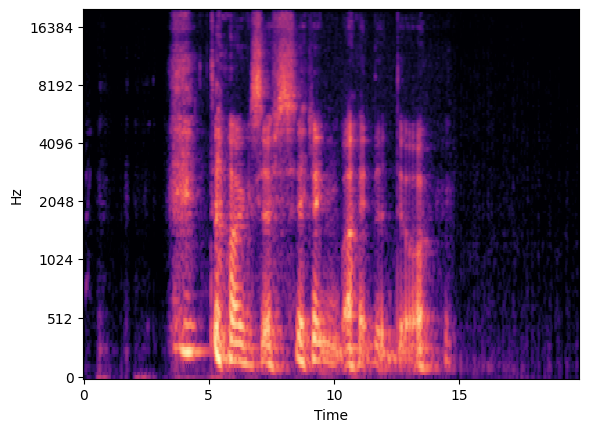

In [15]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');


In [16]:
counter = 0
import re
for folder in folders_main:
    path_in = os.path.join(path_main, folder)

    # List files in the current folder
    files_sub = os.listdir(path_in)
    for file in files_sub:
        numbers = re.findall('\d+', file)

        # Get the emotion from the filename using the dictionary
        if len(numbers) > 2 and numbers[2] in dicts:
            emotion = dicts[numbers[2]]
        else:
            print(f"Skipping file {file} due to invalid emotion code.")
            continue

        print(f"Processing file: {file}, Emotion: {emotion}")

        # Construct paths for saving and loading
        path_save = os.path.join(images, f'{emotion}/{file}.jpeg')
        path_load = os.path.join(path_in, file)

        # Ensure the folder for the emotion exists
        if not os.path.exists(os.path.dirname(path_save)):
            os.makedirs(os.path.dirname(path_save))

        try:
            # Load the audio file
            y, sr = librosa.load(path_load)
            yt, _ = librosa.effects.trim(y)
            y = yt

            # Create the mel spectrogram
            mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            db_spec = librosa.power_to_db(mel_spect)
            # print("mel created for :", path_save)

            # save the spectrogram
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel spectrogram for {file}')
            plt.tight_layout()
            plt.savefig(path_save)
            # plt.show()
            plt.close()
            counter += 1

        except Exception as e:
            print(f"Error processing file {file}: {e}")

Processing file: 03-01-05-01-01-02-17.wav, Emotion: angry
Processing file: 03-01-01-01-01-01-17.wav, Emotion: neutral
Processing file: 03-01-02-01-02-01-17.wav, Emotion: calm
Processing file: 03-01-08-01-02-02-17.wav, Emotion: surprised
Processing file: 03-01-02-01-01-01-17.wav, Emotion: calm
Processing file: 03-01-03-01-01-01-17.wav, Emotion: happy
Processing file: 03-01-03-01-02-02-17.wav, Emotion: happy
Processing file: 03-01-05-02-01-01-17.wav, Emotion: angry
Processing file: 03-01-07-01-02-01-17.wav, Emotion: disgust
Processing file: 03-01-08-01-01-01-17.wav, Emotion: surprised
Processing file: 03-01-03-02-01-01-17.wav, Emotion: happy
Processing file: 03-01-04-02-02-01-17.wav, Emotion: sad
Processing file: 03-01-03-02-02-02-17.wav, Emotion: happy
Processing file: 03-01-07-01-01-02-17.wav, Emotion: disgust
Processing file: 03-01-05-02-01-02-17.wav, Emotion: angry
Processing file: 03-01-08-02-01-02-17.wav, Emotion: surprised
Processing file: 03-01-04-02-01-02-17.wav, Emotion: sad
Pr

In [17]:
print(f"Processed {counter} files successfully.")

Processed 1440 files successfully.


[top](#t0)

##### <a id = 'tl5'>
<font size = 10 color = 'midnightblue'> <b> Transfer Learning

### <a id = 't5.1'>
<font size = 6 color = pwdrblue> <b> Import the training and test images with labels.

<div class="alert alert-block alert-success">
<font size = 4>
    
<b>- Using the glob module in Python to retrieve file paths from specific directories


In [18]:
import glob

# use the glob.glob function to get a list of file paths for all files in the 'angry' directory.
# The *.* pattern matches all files regardless of their extension.

angry = glob.glob('/content/sample_data/logmel//angry/*.*')
calm = glob.glob('/content/sample_data/logmel//calm/*.*')
disgust = glob.glob('/content/sample_data/logmel//disgust/*.*')
fearful = glob.glob('/content/sample_data/logmel//fearful/*.*')
happy = glob.glob('/content/sample_data/logmel//happy/*.*')
neutral = glob.glob('/content/sample_data/logmel//neutral/*.*')
sad = glob.glob('/content/sample_data/logmel//sad/*.*')
surprised = glob.glob('/content/sample_data/logmel//surprised/*.*')

In [19]:
pwd()

'/content/ravdess-emotional-speech-audio'

In [20]:
fm = os.listdir('/content/sample_data/logmel//')
fm = [f for f in fm if f not in ('.ipynb_checkpoints')]
fm

['sad', 'surprised', 'happy', 'angry', 'neutral', 'calm', 'fearful', 'disgust']

In [21]:
# Get Count of files in each emotion
for em in fm:
    exec(f"length = len({em})")
    print(f"{em}\t\t: ", length)

sad		:  192
surprised		:  192
happy		:  192
angry		:  192
neutral		:  96
calm		:  192
fearful		:  192
disgust		:  192


In [22]:
data = []
labels = []

for i in angry:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Angry')

for i in calm:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Calm')

for i in disgust:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Disgust')

for i in fearful:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Fearful')

for i in happy:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Happy')

for i in neutral:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Neutral')

for i in sad:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Sad')

for i in surprised:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Surprised')


data = np.array(data)
labels = np.array(labels)

In [23]:
len(data)

1440

In [24]:
def get_images(directory):
    Images = []
    Labels = []
    label = 0

    for labels in os.listdir(directory):
        if labels == 'angry':
            label = 'angry'
        elif labels == 'calm':
            label = 'calm'
        elif labels == 'disgust':
            label = 'disgust'
        elif labels == 'fearful':
            label = 'fearful'
        elif labels == 'happy':
            label = 'happy'
        elif labels == 'neutral':
            label = 'neutral'
        elif labels == 'sad':
            label = 'sad'
        elif labels == 'surprised':
            label = 'surprised'

        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(75,75)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            # image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            Images.append(image)
            Labels.append(label)

    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {'angry':'angry', 'calm':'calm', 'disgust':'disgust', 'fearful':'fearful', 'happy':'happy', 'neutral':'neutral','sad':'sad','surprised':'surprised'}

    return labels[class_code]

In [25]:
Images, Labels = get_images('/content/sample_data/logmel/') #Extract the training images from the folders.


In [26]:
len(Images)

1440

[top](#t0)

### <a id = 't5.2'>
<font size = 6 color = pwdrblue> <b>  Process Images for Transfer Learning

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.3,random_state=22, stratify=Labels)

In [28]:
lb = LabelEncoder()

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# y_val=np_utils.to_categorical(lb.fit_transform(y_val))
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [29]:
X_test.shape

(432, 75, 75, 3)

In [30]:
X_train.shape

(1008, 75, 75, 3)

### <a id = 't5.3'>
<font size = 6 color = pwdrblue> <b>  Using VGG16 model

In [31]:
from tensorflow.keras import applications
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (75, 75, 3),pooling='avg')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


<div class="alert alert-block alert-success">
<font size = 4>
    
- weights = ‘imagenet’ : use the pretrained weights instead of training the model from scratch
- include_top=False : we want to load the model without the classifier layers and add our own
- input_shape=(75, 75, 3): specify the preferred shape of the images in our dataset

[top](#t0)

### <a id = 't5.4'>
<font size = 6 color = pwdrblue> <b> Freeze the convolution blocks

In [32]:
for layer in model.layers[:17]:
  layer.trainable = False

#Adding custom Layers

x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)

[top](#t0)

### <a id = 't5.5'>
<font size = 6 color = pwdrblue> <b> Create the dense layers and compile

In [33]:
predictions = Dense(8, activation="softmax")(x)

# creating the final model
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [34]:
model_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 75, 75, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │              

 Total params: 15,110,728 (57.64 MB)

 Trainable params: 2,755,848 (10.51 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

[top](#t0)

### <a id = 't5.6'>
<font size = 6 color = pwdrblue> <b> Fit the model

In [35]:
history = model_final.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.2071 - loss: 2.0728 - val_accuracy: 0.2569 - val_loss: 1.8178
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2771 - loss: 1.8577 - val_accuracy: 0.3565 - val_loss: 1.6505
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3396 - loss: 1.6899 - val_accuracy: 0.3889 - val_loss: 1.6363
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4257 - loss: 1.5482 - val_accuracy: 0.4190 - val_loss: 1.5186
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4459 - loss: 1.4647 - val_accuracy: 0.4491 - val_loss: 1.4934
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5337 - loss: 1.3158 - val_accuracy: 0.4931 - val_loss: 1.3892
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5111 - loss: 1.3127 - val_accuracy: 0.4884 - val_loss: 1.4851
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5202 - loss: 1.2949 - val_accuracy: 

[top](#t0)

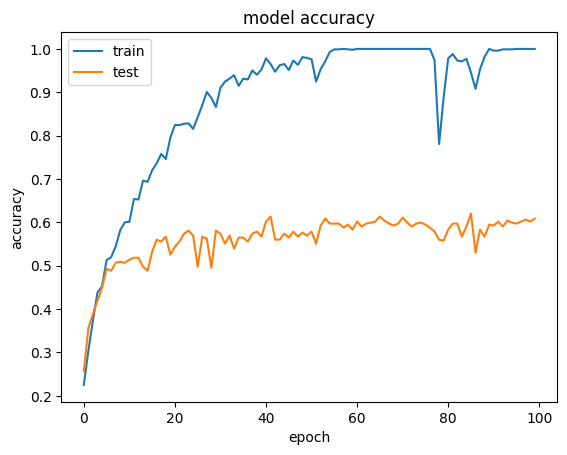

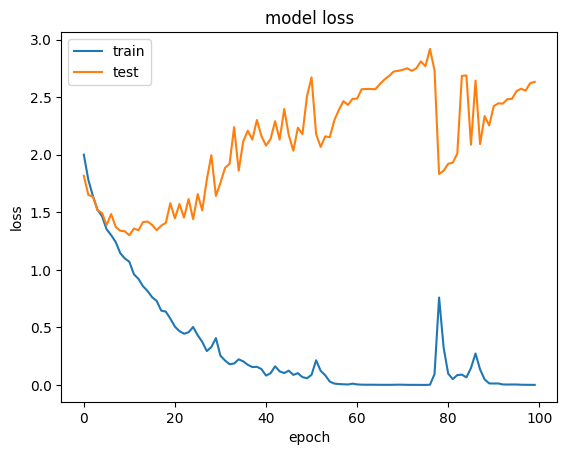

In [36]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <a id = 't5.8'>
<font size = 6 color = pwdrblue> <b> Evaluation using confusion matrix

In [37]:
Y_pred = model_final.predict(X_test)
y_pred = np.argmax(Y_pred,axis=1) # classes
Y_true = np.argmax(y_test,axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [38]:
categories = { int(i)-1 : dicts[i] for i in dicts.keys()}

In [39]:
category_names = categories.values()
category_names

dict_values(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
categories

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

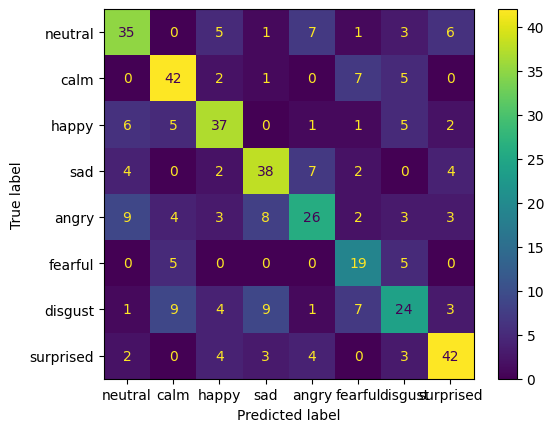

In [42]:
cm = confusion_matrix(Y_true, y_pred)
ConfusionMatrixDisplay.from_predictions( y_true = Y_true, y_pred = y_pred, display_labels= categories.values())
plt.show()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, y_pred, target_names = categories.values()))

              precision    recall  f1-score   support

     neutral       0.61      0.60      0.61        58
        calm       0.65      0.74      0.69        57
       happy       0.65      0.65      0.65        57
         sad       0.63      0.67      0.65        57
       angry       0.57      0.45      0.50        58
     fearful       0.49      0.66      0.56        29
     disgust       0.50      0.41      0.45        58
   surprised       0.70      0.72      0.71        58

    accuracy                           0.61       432
   macro avg       0.60      0.61      0.60       432
weighted avg       0.61      0.61      0.60       432



In [44]:
from sklearn.metrics import accuracy_score

In [45]:
accuracy = accuracy_score(Y_true, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 60.9% 


### Image Augmentation

### Generating Augmented Images

In [46]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( zoom_range=0.3, rotation_range=20,
                                   width_shift_range=0.15)

#### example:

In [47]:
img_id = 3
img_generator = train_datagen.flow(X_train[img_id:img_id+1], y_train[img_id:img_id+1],
                                   batch_size=1)

In [48]:
angry_img = [next(img_generator) for i in range(0,5)]

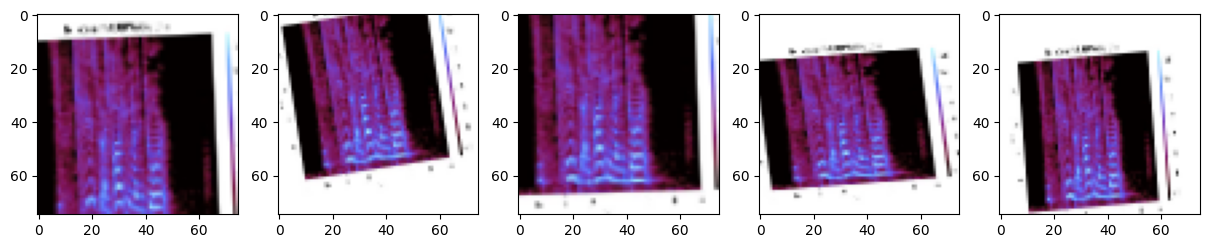

In [49]:

fig, ax = plt.subplots(1,5, figsize=(15, 6))
i = 0
for item in angry_img:
    ax[i].imshow(item[0][0])
    i = i+1
plt.show()

#### genertaing for train data

In [50]:
train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=1)

#### model

In [51]:
augmen_model = applications.VGG16(weights = "imagenet", include_top=False,
                                  input_shape = (75, 75, 3),pooling='avg')

#### Freezing Layers

In [52]:
for layer in augmen_model.layers[:17]:
    layer.trainable = False

#Adding custom Layers

x = augmen_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)

In [53]:
predictions = Dense(8, activation="softmax")(x)

In [54]:
# creating the final model
aug_model_final = Model(inputs = augmen_model.input, outputs = predictions)

In [55]:
# compile the model
aug_model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [56]:
aug_model_final.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 75, 75, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │              

 Total params: 15,110,728 (57.64 MB)

 Trainable params: 2,755,848 (10.51 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [57]:
history = aug_model_final.fit(train_generator,
                                    validation_data=(X_test,y_test),
                                    epochs=100, shuffle=True)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.1593 - loss: 2.2821 - val_accuracy: 0.1042 - val_loss: 2.0020
Epoch 2/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2261 - loss: 1.9723 - val_accuracy: 0.3032 - val_loss: 1.8213
Epoch 3/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2172 - loss: 1.9347 - val_accuracy: 0.2731 - val_loss: 1.8177
Epoch 4/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2578 - loss: 1.8693 - val_accuracy: 0.3148 - val_loss: 1.7154
Epoch 5/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2994 - loss: 1.8644 - val_accuracy: 0.2616 - val_loss: 1.8707
Epoch 6/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3152 - loss: 1.7780 - val_accuracy: 0.3519 - val_loss: 1.6486
Epoch 7/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2772 - loss: 1.8216 - val_accuracy: 0.3194 - val_loss: 1.7593
Epoch 8/100
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3168 - loss: 1.7741 -

In [58]:
history.history

{'accuracy': [0.181547611951828,
  0.22420634329319,
  0.247023805975914,
  0.2539682686328888,
  0.306547611951828,
  0.3025793731212616,
  0.2867063581943512,
  0.3075396716594696,
  0.2946428656578064,
  0.3442460298538208,
  0.3402777910232544,
  0.3303571343421936,
  0.3382936418056488,
  0.3492063581943512,
  0.3363095223903656,
  0.352182537317276,
  0.3402777910232544,
  0.36408731341362,
  0.3571428656578064,
  0.3601190447807312,
  0.358134925365448,
  0.3601190447807312,
  0.3710317313671112,
  0.3819444477558136,
  0.3720238208770752,
  0.3740079402923584,
  0.36408731341362,
  0.3650793731212616,
  0.3948412835597992,
  0.3839285671710968,
  0.3710317313671112,
  0.3888888955116272,
  0.38591268658638,
  0.4047619104385376,
  0.391865074634552,
  0.4007936418056488,
  0.3839285671710968,
  0.3849206268787384,
  0.4027777910232544,
  0.3958333432674408,
  0.4097222089767456,
  0.4077380895614624,
  0.3998015820980072,
  0.3710317313671112,
  0.3968254029750824,
  0.38988095

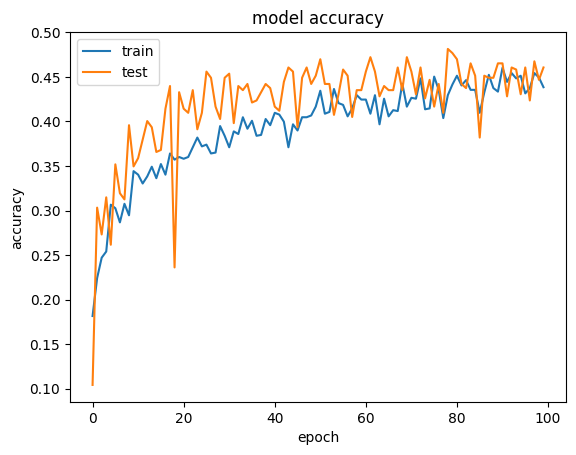

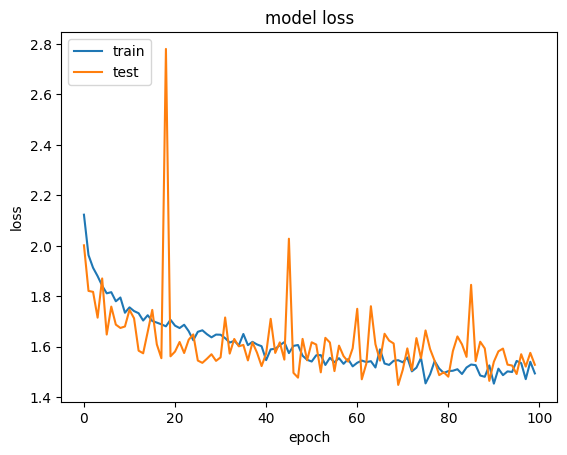

In [59]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <a id = 't5.8'>
<font size = 6 color = pwdrblue> <b> Evaluation using confusion matrix

In [60]:
Y_pred = aug_model_final.predict(X_test)
y_pred = np.argmax(Y_pred,axis=1) # classes
Y_true = np.argmax(y_test,axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [61]:
Y_pred.shape

(432, 8)

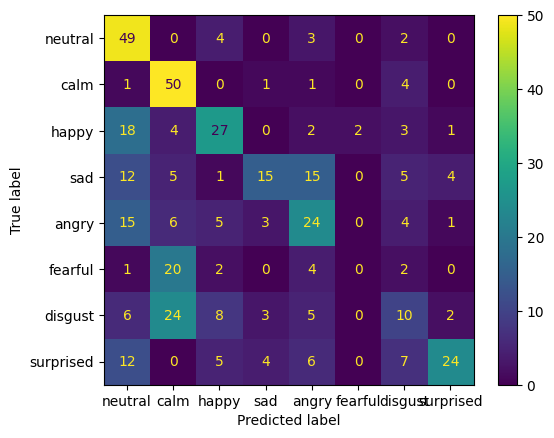

In [62]:
cm = confusion_matrix(Y_true, y_pred)
ConfusionMatrixDisplay.from_predictions( y_true = Y_true, y_pred = y_pred, display_labels= categories.values())
plt.show()

In [63]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, y_pred, target_names =['angry','calm','disgust','fearful','happy','neutral','sad','surprised']))

              precision    recall  f1-score   support

       angry       0.43      0.84      0.57        58
        calm       0.46      0.88      0.60        57
     disgust       0.52      0.47      0.50        57
     fearful       0.58      0.26      0.36        57
       happy       0.40      0.41      0.41        58
     neutral       0.00      0.00      0.00        29
         sad       0.27      0.17      0.21        58
   surprised       0.75      0.41      0.53        58

    accuracy                           0.46       432
   macro avg       0.43      0.43      0.40       432
weighted avg       0.45      0.46      0.42       432



In [64]:
accuracy = accuracy_score(Y_true, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 46.1% 
